In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy import signal

# Butterworth Filtering

Let's look at [Butterworth Filters](https://en.wikipedia.org/wiki/Butterworth_filter) as a useful example for bandpassing.  Butterworth filters are designed to have very flat responses in the pass-band.  We can construct lowpass or highpass filters, with a single cutoff frequency, or we can construct a bandpass filter with a lower and upper frequency cutoff.  We're also free to choose the _order_ of the filter, which drives how quickly the response rolls off at the cutoff freqenc{y,ies}.

In [2]:
from scipy.signal import butter, lfilter

def butter_bandpass(lowcut, highcut, fs, order=5):
    """Construct a bandpass filter, return numerator and
       denominator polynomials of the IIR filter."""
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    """Filter a time series with a butteworth bandpass filter"""
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

Let's construct a bandpass filter for a time series sampled at 5 kHz, with the pass
band spanning 500 Hz to 1250 Hz.  We'll use the `freqz()` function to plot the
amplitude response (i.e., gain), for several choices for filter order.

In [3]:
from scipy.signal import freqz

# Sample rate and desired cutoff frequencies (in Hz).
fs = 5000.0
lowcut = 500.0
highcut = 1250.0

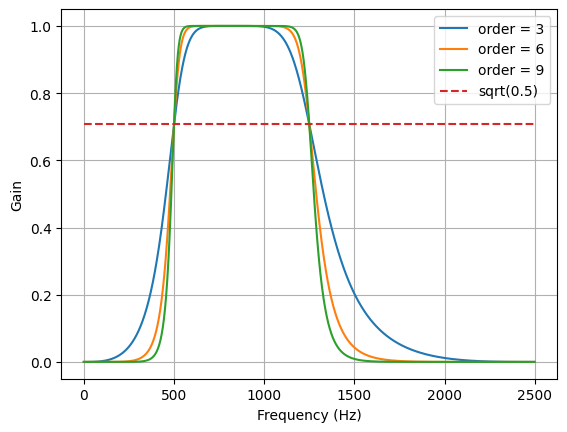

In [4]:
for order in [3, 6, 9]:
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    w, h = freqz(b, a, worN=2000)
    plt.plot((fs * 0.5 / np.pi) * w, abs(h), label="order = %d" % order)

plt.plot([0, 0.5 * fs], [np.sqrt(0.5), np.sqrt(0.5)],
         '--', label='sqrt(0.5)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Gain')
plt.grid(True)
plt.legend(loc='best');

Now let's construct some mock data with a 600 Hz sinusoidal component of interest.

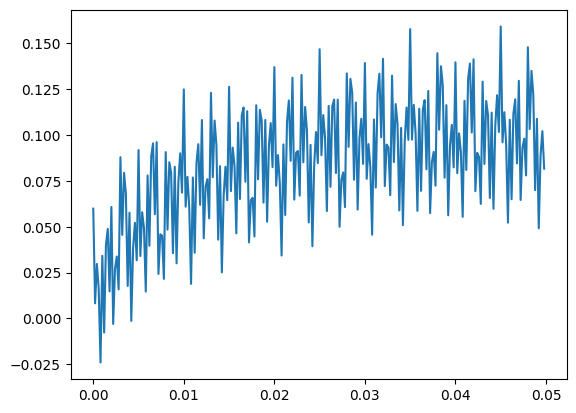

In [5]:
T = 0.05 # data duration
nsamples = int(T * fs)
t = np.linspace(0, T, nsamples, endpoint=False)

a = 0.02
f0 = 600.0

x = 0.1 * np.sin(2 * np.pi * 1.2 * np.sqrt(t))
x += 0.01 * np.cos(2 * np.pi * 312 * t + 0.1)
x += a * np.cos(2 * np.pi * f0 * t + .11)
x += 0.03 * np.cos(2 * np.pi * 2000 * t)

plt.plot(t, x, label='Noisy signal');

Now let's apply the bandpass filter we've constructed.

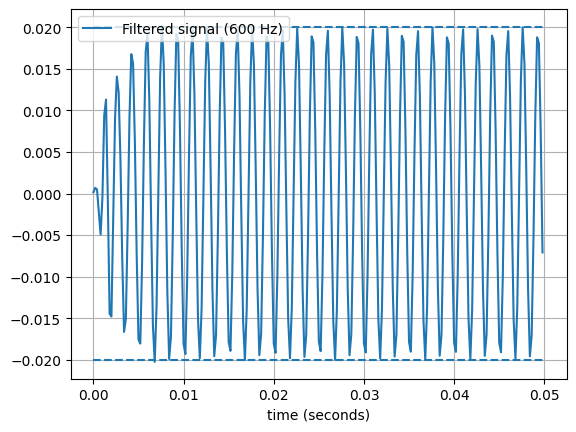

In [6]:
y = butter_bandpass_filter(x, lowcut, highcut, fs, order=6)

plt.plot(t, y, label='Filtered signal (%g Hz)' % f0)
plt.xlabel('time (seconds)')
plt.hlines([-a, a], 0, T, linestyles='--')
plt.grid(True)
plt.axis('tight')
plt.legend(loc='upper left');

Nice.

# Pulsars

Now lets download from [pulsar measurements](http://www.jb.man.ac.uk/research/pulsar/Education/Sounds/) and explore.  These will be MP3's, which we'll use `pydub` to read.

In [7]:
from scipy.io.wavfile import read
from pydub import AudioSegment

from IPython.display import Audio

First up is `PSR B0329+54`, the brightest radio pulsar in the Northern hemisphere.

In [8]:
!wget http://www.jb.man.ac.uk/research/pulsar/Education/Sounds/0329.mp3

overwriting variable {'LAL_DATA_PATH'}
Exported key ADS_API_TOKEN
--2023-06-06 22:40:28--  http://www.jb.man.ac.uk/research/pulsar/Education/Sounds/0329.mp3
Resolving www.jb.man.ac.uk (www.jb.man.ac.uk)... 130.88.24.62
Connecting to www.jb.man.ac.uk (www.jb.man.ac.uk)|130.88.24.62|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.jb.man.ac.uk/research/pulsar/Education/Sounds/0329.mp3 [following]
--2023-06-06 22:40:29--  https://www.jb.man.ac.uk/research/pulsar/Education/Sounds/0329.mp3
Connecting to www.jb.man.ac.uk (www.jb.man.ac.uk)|130.88.24.62|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 180252 (176K) [audio/mpeg]
Saving to: ‘0329.mp3.2’

0329.mp3.2          100%[===================>] 176.03K   317KB/s    in 0.6s    

2023-06-06 22:40:30 (317 KB/s) - ‘0329.mp3.2’ saved [180252/180252]



In [9]:
psr_0329 = AudioSegment.from_mp3("0329.mp3")
srate = psr_0329.frame_rate
psr_0329 = psr_0329.get_array_of_samples()

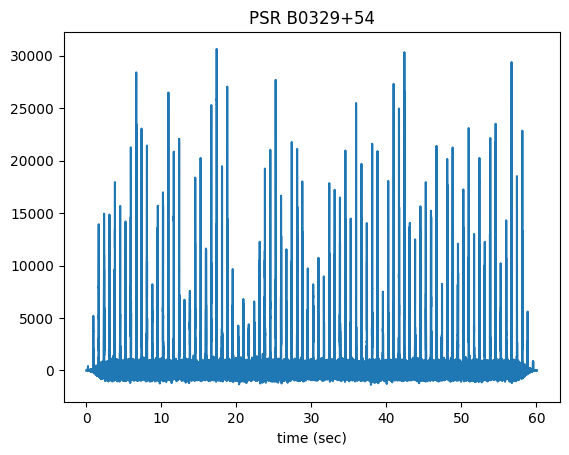

In [10]:
ts = np.arange(len(psr_0329))/srate
window = signal.windows.tukey(len(psr_0329), alpha=.1)

plt.plot(ts, window*psr_0329)
plt.xlabel('time (sec)')
plt.title('PSR B0329+54');

In [11]:
Audio(psr_0329, rate=srate)

Let's look at the spectrogram.

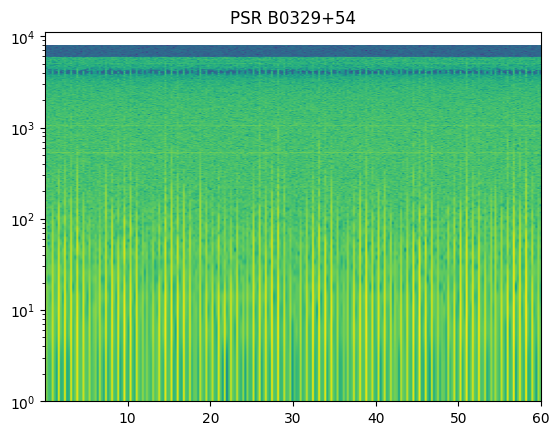

In [12]:
plt.specgram(psr_0329, Fs=srate, NFFT=2**12);
plt.gca().set_yscale('log')
plt.ylim(bottom=1)
plt.title('PSR B0329+54');

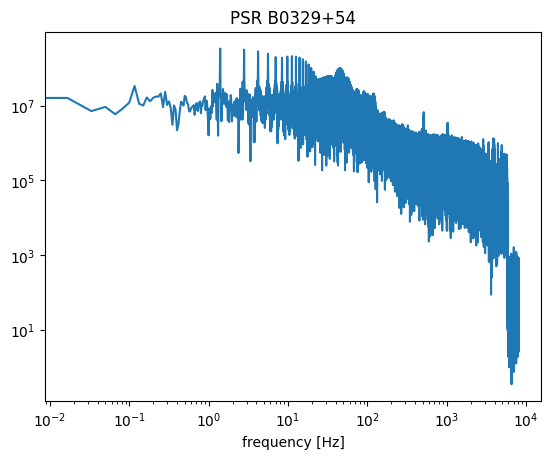

In [13]:
fdata = np.fft.rfft(psr_0329)
freqs = np.fft.rfftfreq(len(psr_0329), d=1/srate)
plt.loglog(freqs, np.abs(fdata))
plt.xlabel('frequency [Hz]')
plt.title('PSR B0329+54');

We can see the pulsar's frequency stand out, as well as its harmonics (i.e., multiples of the fundamental frequency).  Now let's use [Welch's method](https://en.wikipedia.org/wiki/Welch%27s_method) to estimate the power spectral density of the data with less noise, but lower (frequency) resolution.

In [14]:
f, psd = signal.welch(psr_0329, srate, nperseg=8*srate, scaling='spectrum')

Peak power at 1.375 Hz


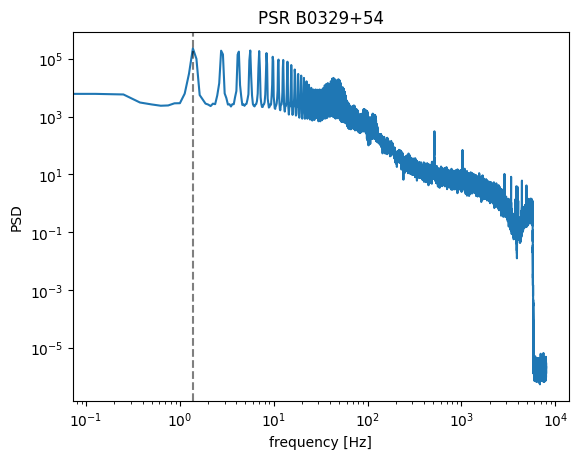

In [15]:
plt.loglog(f, psd)
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD')
plt.title('PSR B0329+54')

f_peak = f[psd.argmax()]
print("Peak power at {} Hz".format(f_peak))
plt.axvline(f_peak, color='k', ls='--', alpha=0.5);

We find the peak power at 1.375 Hz, or a perior of 0.727 seconds.  Given the resolution of our PSD this is consistent with the known period of the pulsar (0.714520 seconds). 

Now let's do the same for `PSD 0437-4715`, the brightest *millisecond* pulsar, which has been spun up by accreting mass from it's binary partner.

In [16]:
!wget http://www.jb.man.ac.uk/research/pulsar/Education/Sounds/0437.mp3

overwriting variable {'LAL_DATA_PATH'}
Exported key ADS_API_TOKEN
--2023-06-06 22:40:34--  http://www.jb.man.ac.uk/research/pulsar/Education/Sounds/0437.mp3
Resolving www.jb.man.ac.uk (www.jb.man.ac.uk)... 130.88.24.62
Connecting to www.jb.man.ac.uk (www.jb.man.ac.uk)|130.88.24.62|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.jb.man.ac.uk/research/pulsar/Education/Sounds/0437.mp3 [following]
--2023-06-06 22:40:34--  https://www.jb.man.ac.uk/research/pulsar/Education/Sounds/0437.mp3
Connecting to www.jb.man.ac.uk (www.jb.man.ac.uk)|130.88.24.62|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 180252 (176K) [audio/mpeg]
Saving to: ‘0437.mp3.1’

0437.mp3.1          100%[===================>] 176.03K   343KB/s    in 0.5s    

2023-06-06 22:40:36 (343 KB/s) - ‘0437.mp3.1’ saved [180252/180252]



In [17]:
psr_0437 = AudioSegment.from_mp3("0437.mp3")
srate = psr_0437.frame_rate
psr_0437 = psr_0437.get_array_of_samples()

In [18]:
Audio(psr_0437, rate=srate)

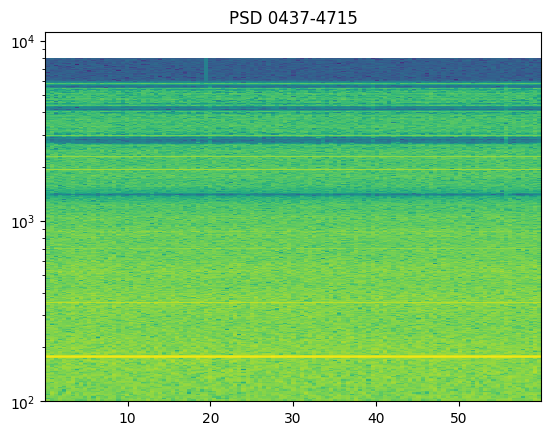

In [19]:
plt.specgram(psr_0437, Fs=srate, NFFT=2**13);
plt.gca().set_yscale('log')
plt.ylim(bottom=100)
plt.title('PSD 0437-4715');

In [20]:
f, psd = signal.welch(psr_0437, srate, nperseg=srate, scaling='spectrum')

Peak power at 174.0 Hz


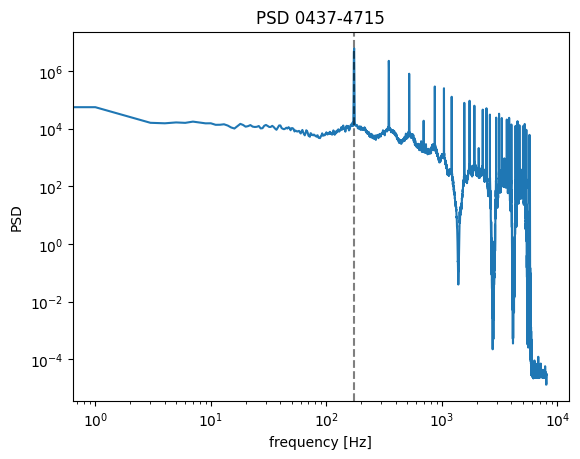

In [21]:
plt.loglog(f, psd)
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD')
plt.title('PSD 0437-4715')

f_peak = f[psd.argmax()]
print("Peak power at {} Hz".format(f_peak))
plt.axvline(f_peak, color='k', ls='--', alpha=0.5);

Finally, let's look at `PSR B0531+21`, better known as the Crab pulsar.

In [22]:
!wget http://www.jb.man.ac.uk/research/pulsar/Education/Sounds/0531.mp3

overwriting variable {'LAL_DATA_PATH'}
Exported key ADS_API_TOKEN
--2023-06-06 22:40:37--  http://www.jb.man.ac.uk/research/pulsar/Education/Sounds/0531.mp3
Resolving www.jb.man.ac.uk (www.jb.man.ac.uk)... 130.88.24.62
Connecting to www.jb.man.ac.uk (www.jb.man.ac.uk)|130.88.24.62|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.jb.man.ac.uk/research/pulsar/Education/Sounds/0531.mp3 [following]
--2023-06-06 22:40:37--  https://www.jb.man.ac.uk/research/pulsar/Education/Sounds/0531.mp3
Connecting to www.jb.man.ac.uk (www.jb.man.ac.uk)|130.88.24.62|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 90288 (88K) [audio/mpeg]
Saving to: ‘0531.mp3.1’

0531.mp3.1          100%[===================>]  88.17K   259KB/s    in 0.3s    

2023-06-06 22:40:38 (259 KB/s) - ‘0531.mp3.1’ saved [90288/90288]



In [23]:
psr_0531 = AudioSegment.from_mp3("0531.mp3")
srate = psr_0531.frame_rate
psr_0531 = psr_0531.get_array_of_samples()

In [24]:
Audio(psr_0531, rate=srate)

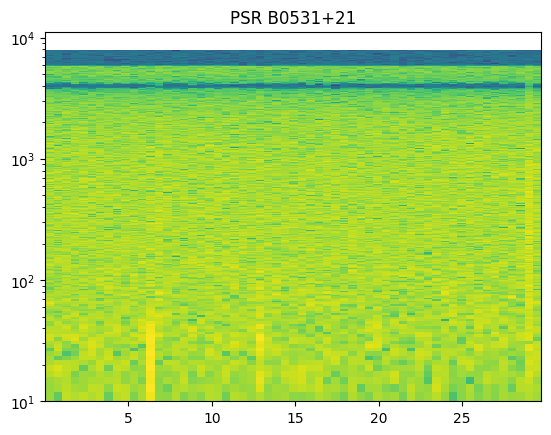

In [25]:
plt.specgram(psr_0531, Fs=srate, NFFT=2**13);
plt.gca().set_yscale('log')
plt.ylim(bottom=10)
plt.title('PSR B0531+21');

In [26]:
f, psd = signal.welch(psr_0531, srate, nperseg=2*srate, scaling='spectrum')

Peak power at 33.0 Hz


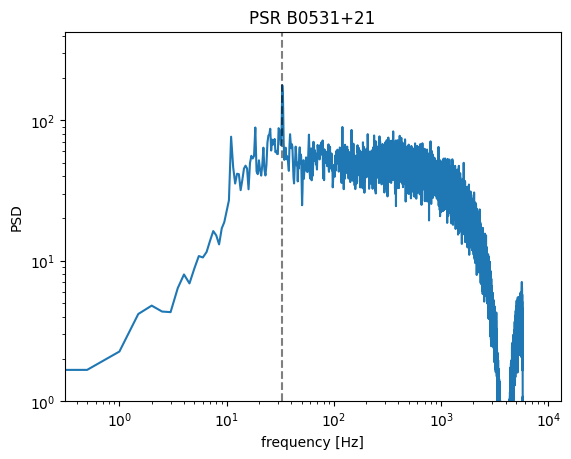

In [27]:
plt.loglog(f, psd)
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD')
plt.ylim(bottom=1)
plt.title('PSR B0531+21')

f_peak = f[psd.argmax()]
print("Peak power at {} Hz".format(f_peak))
plt.axvline(f_peak, color='k', ls='--', alpha=0.5);